# Deep Reinforcement Learning: Algorithm Comparison

This notebook demonstrates and compares four actor-critic algorithms for continuous control:
- **DDPG** - Deep Deterministic Policy Gradient (original, 400-300 architecture)
- **TD3** - Twin Delayed Deep Deterministic Policy Gradient
- **QRTD3** - Quantile Regression TD3
- **GaussianTD3** - Gaussian TD3

## ⚙️ Configuration & Timesteps

**Current Settings (for quick testing):**
- **Max Timesteps**: 10,000 (reduced for fast testing)
- **Start Timesteps**: 1,000 (random exploration phase)
- **Evaluation Frequency**: Every 2,000 timesteps

**For Full Training:**
- Change `MAX_TIMESTEPS` to `int(1e6)` (1 million timesteps) in the Configuration cell
- Recommended: `START_TIMESTEPS = int(25e3)` and `EVAL_FREQ = int(5e3)` for full training

## 📚 Notebook Structure

1. **Configuration** - Set environment, seed, and hyperparameters
2. **Imports & Setup** - Import libraries and algorithm implementations
3. **Helper Functions** - Reusable training and evaluation functions
4. **Algorithm Training Sections** - Individual sections for each algorithm:
   - DDPG
   - TD3
   - QRTD3
   - GaussianTD3
   Each section trains the algorithm and shows its individual learning curve
5. **Algorithm Comparison** - Compare all algorithms from current training session
6. **Advanced Visualization** - Load and visualize saved results from multiple seeds with error bars

## 📊 Visualizing Existing Results

At the end of the notebook, there's an **"Advanced Visualization"** section that allows you to:
- Load previously saved results from multiple seeds (from `./results/{ENV_NAME}/{POLICY}/{seed}.npy` files)
- Create publication-quality plots with error bars showing variance across seeds
- Generate detailed comparison tables with statistics

**To use existing results:**
1. Ensure you have results saved in `./results/{ENV_NAME}/{POLICY}/{seed}.npy` format
2. These typically come from command-line training runs: `python main.py --policy TD3 --env Reacher-v5 --seed 0` (repeat for multiple seeds)
3. Run the "Advanced Visualization" section cells to load and visualize all seeds together

All implementations are imported from the Python files in this repository.


## Configuration

Set the environment and seed here.


In [1]:
# Configuration - Set these at the beginning
ENV_NAME = "Reacher-v5"  # Options: Reacher-v5, Ant-v5, HalfCheetah-v5, Hopper-v5, Walker2d-v5, etc.
SEED = 0

# Training hyperparameters (reduced for testing/evaluation)
MAX_TIMESTEPS = int(10e3)  # 10k timesteps for quick testing (set to 1e6 for full training)
START_TIMESTEPS = int(1e3)  # Initial random exploration (reduced for quick testing)
EVAL_FREQ = int(2e3)  # Evaluation frequency (reduced for quick testing)
BATCH_SIZE = 256
DISCOUNT = 0.99
TAU = 0.005
POLICY_NOISE = 0.2
NOISE_CLIP = 0.5
POLICY_FREQ = 2
EXPL_NOISE = 0.1

# Algorithm-specific hyperparameters
ALPHA = 0.5  # For QRTD3 and GaussianTD3
K = 5  # Number of quantiles for QRTD3

print(f"Configuration:")
print(f"  Environment: {ENV_NAME}")
print(f"  Seed: {SEED}")
print(f"  Max timesteps: {MAX_TIMESTEPS:,}")
print(f"  Start timesteps: {START_TIMESTEPS:,}")
print(f"  Evaluation frequency: {EVAL_FREQ:,}")


Configuration:
  Environment: Reacher-v5
  Seed: 0
  Max timesteps: 10,000
  Start timesteps: 1,000
  Evaluation frequency: 2,000


## Imports

Import the necessary libraries and algorithm implementations from the Python files.


In [2]:
import numpy as np
import torch
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(["#2E86AB", "#A23B72", "#F18F01", "#C73E1D"])
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12
import time
import os
import pandas as pd
from glob import glob

# Import algorithm implementations
import utils
import TD3
import DDPG
import QR_TD3
import Gaussian_TD3

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Store results for comparison
all_results = {}


Using device: cpu
PyTorch version: 2.9.1


## Algorithm Overview

### DDPG (Deep Deterministic Policy Gradient)
- **Paper**: [Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971) (Lillicrap et al., 2015)
- Single critic network (400-300 architecture)
- Actor network (400-300 architecture)
- Updates policy every step
- Learning rate: 1e-4 (actor), weight_decay=1e-2 (critic)
- Tau: 0.001

### OurDDPG (Re-tuned DDPG)
- Same as DDPG but with 256-256 architecture
- Learning rate: 3e-4
- Tau: 0.005
- Batch size: 256

### TD3 (Twin Delayed Deep Deterministic Policy Gradient)
- **Paper**: [Addressing Function Approximation Error in Actor-Critic Methods](https://arxiv.org/abs/1802.09477) (Fujimoto et al., 2018)
- **Key improvements over DDPG**:
  1. **Clipped Double Q-Learning**: Uses two critic networks, takes minimum to reduce overestimation
  2. **Delayed Policy Updates**: Updates policy every 2 steps (less frequent than critics)
  3. **Target Policy Smoothing**: Adds clipped noise to target actions
- Twin critics (256-256 architecture each)
- Actor network (256-256 architecture)
- Learning rate: 3e-4
- Tau: 0.005

### QRTD3 (Quantile Regression TD3)
- Extension of TD3 using quantile regression for the critic
- Uses quantile loss instead of MSE loss
- Can better capture uncertainty in value estimates
- Same architecture as TD3 but with quantile-based critics


## Evaluation Function

This function evaluates the policy over multiple episodes without exploration noise.


In [3]:
def eval_policy(policy, env_name, seed, eval_episodes=10):
    """Evaluate the policy over multiple episodes."""
    eval_env = gym.make(env_name)
    avg_reward = 0.
    for _ in tqdm(range(eval_episodes), desc="Evaluating", leave=False):
        state = eval_env.reset(seed=seed + 100)[0]
        done = False
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            avg_reward += reward
    
    avg_reward /= eval_episodes
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    return avg_reward

def train_algorithm(policy_name, env_name, seed, max_timesteps, start_timesteps, 
                   eval_freq, batch_size, discount, tau, policy_noise, noise_clip, 
                   policy_freq, expl_noise, alpha=None, K=None):
    """
    Train an algorithm and return evaluation results.
    
    Returns:
        evaluations: List of evaluation rewards
        timesteps: List of timesteps corresponding to evaluations
    """
    # Create environment
    env = gym.make(env_name)
    
    # Set seeds
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Get environment dimensions
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    
    # Initialize policy
    kwargs = {
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action,
        "discount": discount,
        "tau": tau,
    }
    
    if policy_name == "TD3":
        kwargs["policy_noise"] = policy_noise * max_action
        kwargs["noise_clip"] = noise_clip * max_action
        kwargs["policy_freq"] = policy_freq
        policy = TD3.TD3(**kwargs)
    elif policy_name == "QRTD3":
        kwargs["policy_noise"] = policy_noise * max_action
        kwargs["noise_clip"] = noise_clip * max_action
        kwargs["policy_freq"] = policy_freq
        kwargs["K"] = K if K else 5
        kwargs["alpha"] = alpha if alpha else 0.5
        policy = QR_TD3.QRTD3(**kwargs)
    elif policy_name == "GaussianTD3":
        kwargs["policy_noise"] = policy_noise * max_action
        kwargs["noise_clip"] = noise_clip * max_action
        kwargs["policy_freq"] = policy_freq
        kwargs["alpha"] = alpha if alpha else 0.5
        policy = Gaussian_TD3.GaussianTD3(**kwargs)
    elif policy_name == "OurDDPG":
        policy = OurDDPG.DDPG(**kwargs)
    elif policy_name == "DDPG":
        policy = DDPG.DDPG(**kwargs)
    else:
        raise ValueError(f"Unknown policy: {policy_name}")
    
    # Initialize replay buffer
    replay_buffer = utils.ReplayBuffer(state_dim, action_dim)
    
    # Evaluate untrained policy
    print(f"\n{'='*70}")
    print(f"Training {policy_name} on {env_name} (Seed {seed})")
    print(f"{'='*70}")
    evaluations = [eval_policy(policy, env_name, seed)]
    
    # Initialize training variables
    state = env.reset(seed=seed + 100)[0]
    done = False
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0
    
    start_time = time.time()
    
    print(f"\nStarting training for {max_timesteps:,} timesteps...")
    print(f"Random exploration for first {start_timesteps:,} steps")
    print(f"Evaluation frequency: every {eval_freq:,} steps\n")
    
    # Main training loop
    for t in tqdm(range(int(max_timesteps)), desc=f"Training {policy_name}"):
        episode_timesteps += 1
        
        # Select action randomly or according to policy with exploration noise
        if t < start_timesteps:
            action = env.action_space.sample()
        else:
            action = (
                policy.select_action(np.array(state))
                + np.random.normal(0, max_action * expl_noise, size=action_dim)
            ).clip(-max_action, max_action)
        
        # Perform action in environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0
        
        # Store transition in replay buffer
        replay_buffer.add(state, action, next_state, reward, done_bool)
        
        state = next_state
        episode_reward += reward
        
        # Train agent after collecting sufficient data
        if t >= start_timesteps:
            policy.train(replay_buffer, batch_size)
        
        if done:
            # Reset environment
            state = env.reset(seed=seed + 100)[0]
            done = False
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1
        
        # Evaluate episode
        if (t + 1) % eval_freq == 0:
            eval_reward = eval_policy(policy, env_name, seed)
            evaluations.append(eval_reward)
    
    end_time = time.time()
    duration = end_time - start_time
    hours = int(duration // 3600)
    minutes = int((duration % 3600) // 60)
    seconds = int(duration % 60)
    
    print(f"\n{'='*70}")
    print(f"{policy_name} Training completed!")
    print(f"Training time: {hours:02d}:{minutes:02d}:{seconds:02d}")
    print(f"Initial reward: {evaluations[0]:.3f}")
    print(f"Final reward: {evaluations[-1]:.3f}")
    print(f"Improvement: {evaluations[-1] - evaluations[0]:.3f}")
    print(f"{'='*70}\n")
    
    # Create timesteps array
    timesteps = np.array([0 if i == 0 else i * eval_freq for i in range(len(evaluations))])
    
    return evaluations, timesteps


## Training Setup

Initialize the environment and policy based on the configuration.


### DDPG (Deep Deterministic Policy Gradient)

**Paper**: [Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971) (Lillicrap et al., 2015)

- Single critic network (400-300 architecture)
- Actor network (400-300 architecture)
- Updates policy every step
- Learning rate: 1e-4 (actor), weight_decay=1e-2 (critic)
- Tau: 0.001
- Batch size: 64 (default)

**Note**: This is the original DDPG implementation. There is also `OurDDPG` (re-tuned version with 256-256 architecture, lr=3e-4, tau=0.005) available in the codebase but not included in this comparison.


## Training Loop

The training loop follows the standard off-policy actor-critic procedure:
1. Collect experience by interacting with the environment
2. Store transitions in the replay buffer
3. Sample batches and update the policy
4. Periodically evaluate the policy without exploration noise



Training DDPG on Reacher-v5 (Seed 0)


Evaluation over 10 episodes: -37.748

Starting training for 10,000 timesteps...
Random exploration for first 1,000 steps
Evaluation frequency: every 2,000 steps



Training DDPG:  20%|██        | 2025/10000 [00:06<00:46, 172.87it/s] 

Evaluation over 10 episodes: -7.459


Training DDPG:  40%|████      | 4031/10000 [00:21<00:41, 143.08it/s]

Evaluation over 10 episodes: -4.734


Training DDPG:  60%|██████    | 6020/10000 [00:33<00:27, 143.84it/s]

Evaluation over 10 episodes: -0.868


Training DDPG:  80%|████████  | 8006/10000 [00:45<00:14, 136.23it/s]

Evaluation over 10 episodes: -2.513


Training DDPG: 100%|██████████| 10000/10000 [00:58<00:00, 171.27it/s]


Evaluation over 10 episodes: -0.998

DDPG Training completed!
Training time: 00:00:58
Initial reward: -37.748
Final reward: -0.998
Improvement: 36.750



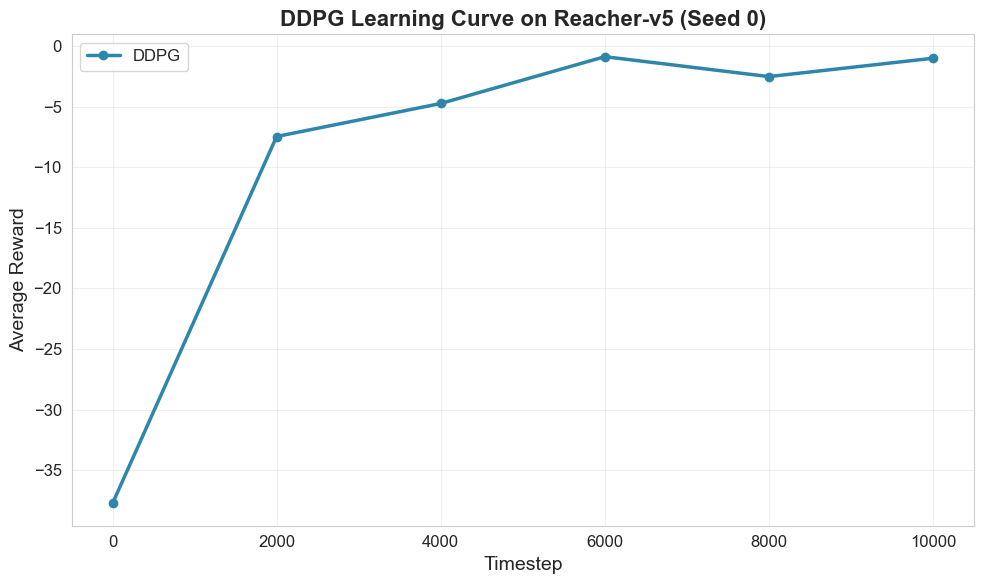

In [4]:
# Train DDPG
ddpg_evaluations, ddpg_timesteps = train_algorithm(
    policy_name="DDPG",
    env_name=ENV_NAME,
    seed=SEED,
    max_timesteps=MAX_TIMESTEPS,
    start_timesteps=START_TIMESTEPS,
    eval_freq=EVAL_FREQ,
    batch_size=BATCH_SIZE,
    discount=DISCOUNT,
    tau=0.001,  # DDPG uses tau=0.001
    policy_noise=POLICY_NOISE,
    noise_clip=NOISE_CLIP,
    policy_freq=POLICY_FREQ,
    expl_noise=EXPL_NOISE
)

# Store results for comparison
all_results["DDPG"] = {"evaluations": ddpg_evaluations, "timesteps": ddpg_timesteps}

# Plot DDPG learning curve
plt.figure(figsize=(10, 6))
plt.plot(ddpg_timesteps, ddpg_evaluations, marker='o', linewidth=2.5, markersize=6, label="DDPG", color='#2E86AB')
plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Average Reward', fontsize=14)
plt.title(f'DDPG Learning Curve on {ENV_NAME} (Seed {SEED})', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Results Visualization

Plot the learning curve showing how the average reward improves over time.



Training TD3 on Reacher-v5 (Seed 0)


Evaluation over 10 episodes: -5.469

Starting training for 10,000 timesteps...
Random exploration for first 1,000 steps
Evaluation frequency: every 2,000 steps



Training TD3:  20%|█▉        | 1965/10000 [00:04<00:21, 374.30it/s] 

Evaluation over 10 episodes: -2.259


Training TD3:  40%|████      | 4038/10000 [00:14<00:31, 186.51it/s]

Evaluation over 10 episodes: -2.094


Training TD3:  60%|█████▉    | 5996/10000 [00:23<00:18, 217.89it/s]

Evaluation over 10 episodes: -1.404


Training TD3:  80%|████████  | 8034/10000 [00:33<00:10, 188.73it/s]

Evaluation over 10 episodes: -1.021


Training TD3: 100%|██████████| 10000/10000 [00:42<00:00, 233.89it/s]


Evaluation over 10 episodes: -0.888

TD3 Training completed!
Training time: 00:00:42
Initial reward: -5.469
Final reward: -0.888
Improvement: 4.581



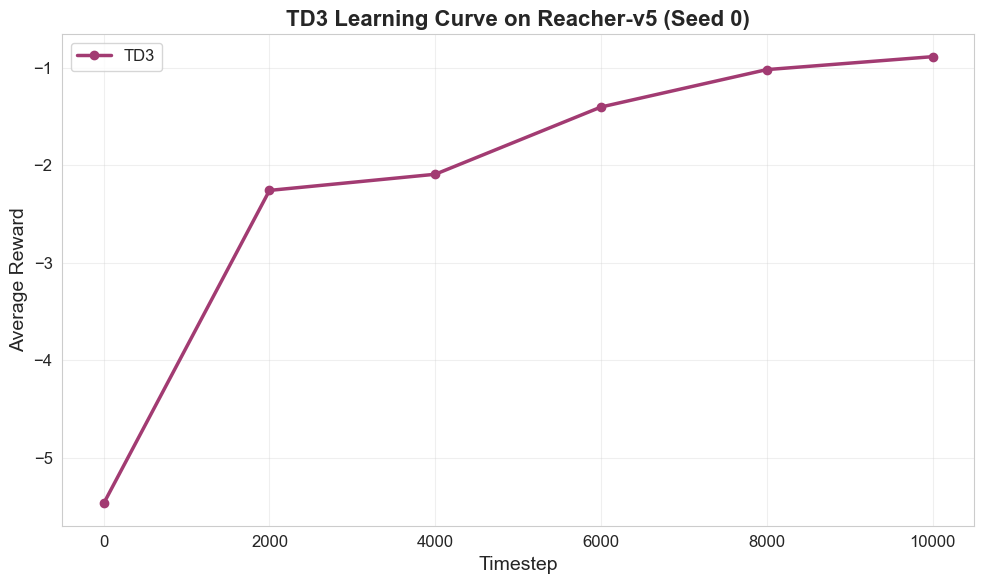

In [5]:
# Train TD3
td3_evaluations, td3_timesteps = train_algorithm(
    policy_name="TD3",
    env_name=ENV_NAME,
    seed=SEED,
    max_timesteps=MAX_TIMESTEPS,
    start_timesteps=START_TIMESTEPS,
    eval_freq=EVAL_FREQ,
    batch_size=BATCH_SIZE,
    discount=DISCOUNT,
    tau=TAU,
    policy_noise=POLICY_NOISE,
    noise_clip=NOISE_CLIP,
    policy_freq=POLICY_FREQ,
    expl_noise=EXPL_NOISE
)

# Store results for comparison
all_results["TD3"] = {"evaluations": td3_evaluations, "timesteps": td3_timesteps}

# Plot TD3 learning curve
plt.figure(figsize=(10, 6))
plt.plot(td3_timesteps, td3_evaluations, marker='o', linewidth=2.5, markersize=6, label="TD3", color='#A23B72')
plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Average Reward', fontsize=14)
plt.title(f'TD3 Learning Curve on {ENV_NAME} (Seed {SEED})', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



Training QRTD3 on Reacher-v5 (Seed 0)


Evaluation over 10 episodes: -5.469

Starting training for 10,000 timesteps...
Random exploration for first 1,000 steps
Evaluation frequency: every 2,000 steps



Training QRTD3:  20%|█▉        | 1991/10000 [00:06<00:28, 281.90it/s] 

Evaluation over 10 episodes: -5.077


Training QRTD3:  40%|████      | 4009/10000 [00:19<00:40, 147.53it/s]

Evaluation over 10 episodes: -4.635


Training QRTD3:  60%|█████▉    | 5986/10000 [00:30<00:23, 174.10it/s]


Step    5000 | Diagnostics (CVaR_50%)
Reward:       mean=   -0.33  std=   0.48
Target Q:     mean=   -3.74  std=   2.23
Current Q:    mean=   -3.48  std=   1.90
Q range:      [  -19.81,    -2.31]
CVaR_50%:         -3.55
Median (50%):    -3.47
Disorder:     0.000000
Critic loss:  0.0109
Critic grad:  0.3252
Actor loss:   3.5469


Step    5000 | Diagnostics
  Reward (unscaled):  mean=   -0.33
  Target Q:           mean=   -3.74
  Current Q:          mean=   -3.48  std=   1.90
  Q range:            [  -19.81,    -2.31]
  Quantile disorder:  0.000000
  Critic loss:        0.0109
  Critic grad norm:   0.3252
  Actor loss:         3.5469



Training QRTD3:  60%|██████    | 6022/10000 [00:30<00:25, 153.65it/s]

Evaluation over 10 episodes: -2.978


Training QRTD3:  80%|████████  | 8024/10000 [00:41<00:12, 155.83it/s]

Evaluation over 10 episodes: -1.038


Training QRTD3: 100%|██████████| 10000/10000 [00:53<00:00, 188.37it/s]


Evaluation over 10 episodes: -1.953

QRTD3 Training completed!
Training time: 00:00:53
Initial reward: -5.469
Final reward: -1.953
Improvement: 3.516



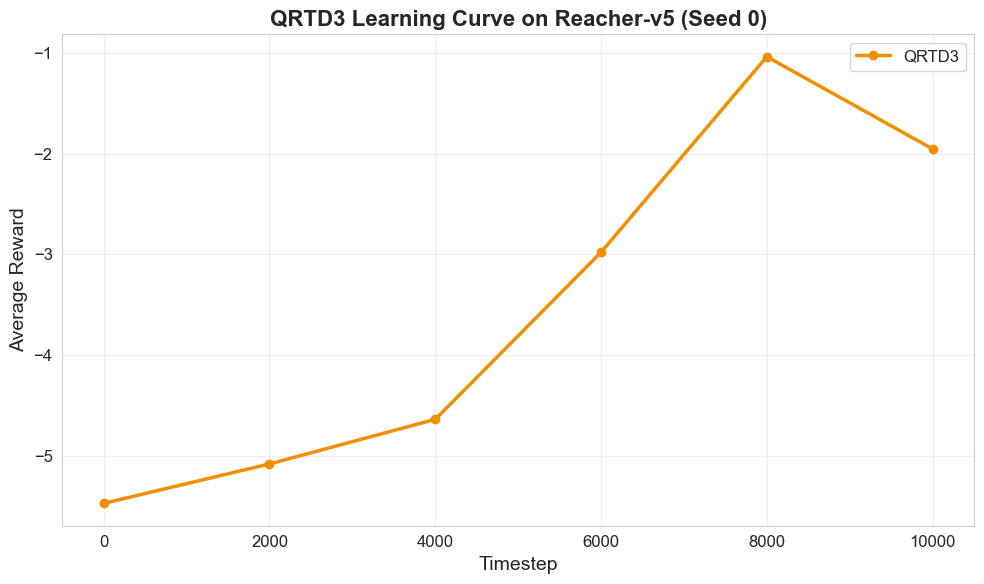

In [6]:
# Train QRTD3
qrtd3_evaluations, qrtd3_timesteps = train_algorithm(
    policy_name="QRTD3",
    env_name=ENV_NAME,
    seed=SEED,
    max_timesteps=MAX_TIMESTEPS,
    start_timesteps=START_TIMESTEPS,
    eval_freq=EVAL_FREQ,
    batch_size=BATCH_SIZE,
    discount=DISCOUNT,
    tau=TAU,
    policy_noise=POLICY_NOISE,
    noise_clip=NOISE_CLIP,
    policy_freq=POLICY_FREQ,
    expl_noise=EXPL_NOISE,
    alpha=ALPHA,
    K=K
)

# Store results for comparison
all_results["QRTD3"] = {"evaluations": qrtd3_evaluations, "timesteps": qrtd3_timesteps}

# Plot QRTD3 learning curve
plt.figure(figsize=(10, 6))
plt.plot(qrtd3_timesteps, qrtd3_evaluations, marker='o', linewidth=2.5, markersize=6, label="QRTD3", color='#F18F01')
plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Average Reward', fontsize=14)
plt.title(f'QRTD3 Learning Curve on {ENV_NAME} (Seed {SEED})', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### GaussianTD3

Extension of TD3 using Gaussian distribution for value estimation.
- Uses Gaussian distribution instead of point estimates
- Can better capture uncertainty in value estimates
- Parameter: `alpha` (risk parameter)



Training GaussianTD3 on Reacher-v5 (Seed 0)


Evaluation over 10 episodes: -5.469

Starting training for 10,000 timesteps...
Random exploration for first 1,000 steps
Evaluation frequency: every 2,000 steps



Training GaussianTD3:  10%|█         | 1003/10000 [00:00<00:00, 9846.45it/s]


Step     500 | Gaussian Distributional TD3
Reward:       mean=   -1.15
Target:       mean=   -1.45
Q Dist:       μ=  -1.55  σ=  0.37
Q Range:      [5%:   -2.17, 95%:   -0.93]
CVaR_50%:         -1.85
Critic loss:  99.6241
Critic grad:  81110.7109
Actor loss:   1.8532



Training GaussianTD3:  20%|█▉        | 1988/10000 [00:06<00:29, 272.83it/s] 


Step    1000 | Gaussian Distributional TD3
Reward:       mean=   -1.15
Target:       mean=   -0.90
Q Dist:       μ=  -0.76  σ=  0.07
Q Range:      [5%:   -0.87, 95%:   -0.65]
CVaR_50%:         -0.81
Critic loss:  -3.5121
Critic grad:  219.4079
Actor loss:   0.8147



Evaluation over 10 episodes: -4.435


Training GaussianTD3:  24%|██▍       | 2403/10000 [00:08<00:33, 229.77it/s]


Step    1500 | Gaussian Distributional TD3
Reward:       mean=   -1.01
Target:       mean=   -1.06
Q Dist:       μ=  -0.79  σ=  0.32
Q Range:      [5%:   -1.31, 95%:   -0.26]
CVaR_50%:         -1.05
Critic loss:  -3.3603
Critic grad:  182.2467
Actor loss:   1.0473



Training GaussianTD3:  30%|███       | 3011/10000 [00:12<00:36, 191.31it/s]


Step    2000 | Gaussian Distributional TD3
Reward:       mean=   -0.83
Target:       mean=   -0.81
Q Dist:       μ=  -0.72  σ=  0.02
Q Range:      [5%:   -0.76, 95%:   -0.69]
CVaR_50%:         -0.74
Critic loss:  -3.1614
Critic grad:  1347.3916
Actor loss:   0.7411



Training GaussianTD3:  35%|███▌      | 3523/10000 [00:15<00:39, 162.07it/s]


Step    2500 | Gaussian Distributional TD3
Reward:       mean=   -0.71
Target:       mean=   -0.59
Q Dist:       μ=  -0.49  σ=  0.11
Q Range:      [5%:   -0.67, 95%:   -0.31]
CVaR_50%:         -0.57
Critic loss:  -4.5950
Critic grad:  263.1775
Actor loss:   0.5747



Training GaussianTD3:  40%|███▉      | 3998/10000 [00:18<00:37, 159.01it/s]


Step    3000 | Gaussian Distributional TD3
Reward:       mean=   -0.67
Target:       mean=   -0.78
Q Dist:       μ=  -0.67  σ=  0.02
Q Range:      [5%:   -0.71, 95%:   -0.63]
CVaR_50%:         -0.69
Critic loss:  -5.1118
Critic grad:  140.2829
Actor loss:   0.6867



Training GaussianTD3:  40%|████      | 4014/10000 [00:19<00:45, 131.60it/s]

Evaluation over 10 episodes: -0.903


Training GaussianTD3:  45%|████▌     | 4518/10000 [00:22<00:33, 161.90it/s]


Step    3500 | Gaussian Distributional TD3
Reward:       mean=   -0.62
Target:       mean=   -0.76
Q Dist:       μ=  -0.66  σ=  0.25
Q Range:      [5%:   -1.07, 95%:   -0.26]
CVaR_50%:         -0.86
Critic loss:  -4.7780
Critic grad:  335.0929
Actor loss:   0.8624



Training GaussianTD3:  50%|█████     | 5028/10000 [00:25<00:30, 161.52it/s]


Step    4000 | Gaussian Distributional TD3
Reward:       mean=   -0.46
Target:       mean=   -0.54
Q Dist:       μ=  -0.49  σ=  0.02
Q Range:      [5%:   -0.53, 95%:   -0.45]
CVaR_50%:         -0.51
Critic loss:  -5.5861
Critic grad:  54.8086
Actor loss:   0.5113



Training GaussianTD3:  55%|█████▌    | 5521/10000 [00:28<00:27, 162.97it/s]


Step    4500 | Gaussian Distributional TD3
Reward:       mean=   -0.48
Target:       mean=   -0.61
Q Dist:       μ=  -0.55  σ=  0.02
Q Range:      [5%:   -0.58, 95%:   -0.52]
CVaR_50%:         -0.57
Critic loss:  -4.9674
Critic grad:  470.9688
Actor loss:   0.5661



Training GaussianTD3:  60%|█████▉    | 5992/10000 [00:31<00:30, 132.38it/s]


Step    5000 | Gaussian Distributional TD3
Reward:       mean=   -0.42
Target:       mean=   -0.51
Q Dist:       μ=  -0.45  σ=  0.05
Q Range:      [5%:   -0.53, 95%:   -0.37]
CVaR_50%:         -0.49
Critic loss:  -5.5022
Critic grad:  266.7870
Actor loss:   0.4904



Training GaussianTD3:  60%|██████    | 6007/10000 [00:31<00:34, 117.38it/s]

Evaluation over 10 episodes: -1.596


Training GaussianTD3:  65%|██████▌   | 6517/10000 [00:34<00:21, 163.22it/s]


Step    5500 | Gaussian Distributional TD3
Reward:       mean=   -0.41
Target:       mean=   -0.54
Q Dist:       μ=  -0.49  σ=  0.07
Q Range:      [5%:   -0.59, 95%:   -0.38]
CVaR_50%:         -0.54
Critic loss:  -5.4693
Critic grad:  158.1686
Actor loss:   0.5393



Training GaussianTD3:  70%|███████   | 7016/10000 [00:38<00:18, 161.84it/s]


Step    6000 | Gaussian Distributional TD3
Reward:       mean=   -0.43
Target:       mean=   -0.60
Q Dist:       μ=  -0.58  σ=  0.14
Q Range:      [5%:   -0.81, 95%:   -0.36]
CVaR_50%:         -0.68
Critic loss:  -5.2322
Critic grad:  366.7921
Actor loss:   0.6845



Training GaussianTD3:  75%|███████▌  | 7526/10000 [00:41<00:15, 161.85it/s]


Step    6500 | Gaussian Distributional TD3
Reward:       mean=   -0.40
Target:       mean=   -0.61
Q Dist:       μ=  -0.56  σ=  0.02
Q Range:      [5%:   -0.60, 95%:   -0.53]
CVaR_50%:         -0.58
Critic loss:  -5.5451
Critic grad:  99.4915
Actor loss:   0.5790



Training GaussianTD3:  80%|███████▉  | 7985/10000 [00:44<00:12, 163.53it/s]


Step    7000 | Gaussian Distributional TD3
Reward:       mean=   -0.30
Target:       mean=   -0.53
Q Dist:       μ=  -0.51  σ=  0.01
Q Range:      [5%:   -0.53, 95%:   -0.48]
CVaR_50%:         -0.52
Critic loss:  -5.5226
Critic grad:  463.0083
Actor loss:   0.5180



Training GaussianTD3:  80%|████████  | 8019/10000 [00:44<00:13, 142.43it/s]

Evaluation over 10 episodes: -1.864


Training GaussianTD3:  85%|████████▌ | 8529/10000 [00:47<00:09, 158.65it/s]


Step    7500 | Gaussian Distributional TD3
Reward:       mean=   -0.35
Target:       mean=   -0.60
Q Dist:       μ=  -0.53  σ=  0.07
Q Range:      [5%:   -0.65, 95%:   -0.41]
CVaR_50%:         -0.59
Critic loss:  -5.1818
Critic grad:  438.2646
Actor loss:   0.5893



Training GaussianTD3:  90%|█████████ | 9021/10000 [00:50<00:06, 163.00it/s]


Step    8000 | Gaussian Distributional TD3
Reward:       mean=   -0.35
Target:       mean=   -0.57
Q Dist:       μ=  -0.51  σ=  0.02
Q Range:      [5%:   -0.54, 95%:   -0.48]
CVaR_50%:         -0.53
Critic loss:  -5.2081
Critic grad:  356.5618
Actor loss:   0.5285



Training GaussianTD3:  95%|█████████▌| 9531/10000 [00:53<00:02, 160.33it/s]


Step    8500 | Gaussian Distributional TD3
Reward:       mean=   -0.37
Target:       mean=   -0.68
Q Dist:       μ=  -0.63  σ=  0.15
Q Range:      [5%:   -0.87, 95%:   -0.38]
CVaR_50%:         -0.74
Critic loss:  -5.3935
Critic grad:  52.7872
Actor loss:   0.7366



Training GaussianTD3: 100%|█████████▉| 9989/10000 [00:56<00:00, 162.35it/s]


Step    9000 | Gaussian Distributional TD3
Reward:       mean=   -0.32
Target:       mean=   -0.56
Q Dist:       μ=  -0.53  σ=  0.01
Q Range:      [5%:   -0.55, 95%:   -0.50]
CVaR_50%:         -0.54
Critic loss:  -5.6788
Critic grad:  142.2264
Actor loss:   0.5399



Training GaussianTD3: 100%|██████████| 10000/10000 [00:56<00:00, 175.66it/s]


Evaluation over 10 episodes: -1.220

GaussianTD3 Training completed!
Training time: 00:00:56
Initial reward: -5.469
Final reward: -1.220
Improvement: 4.249



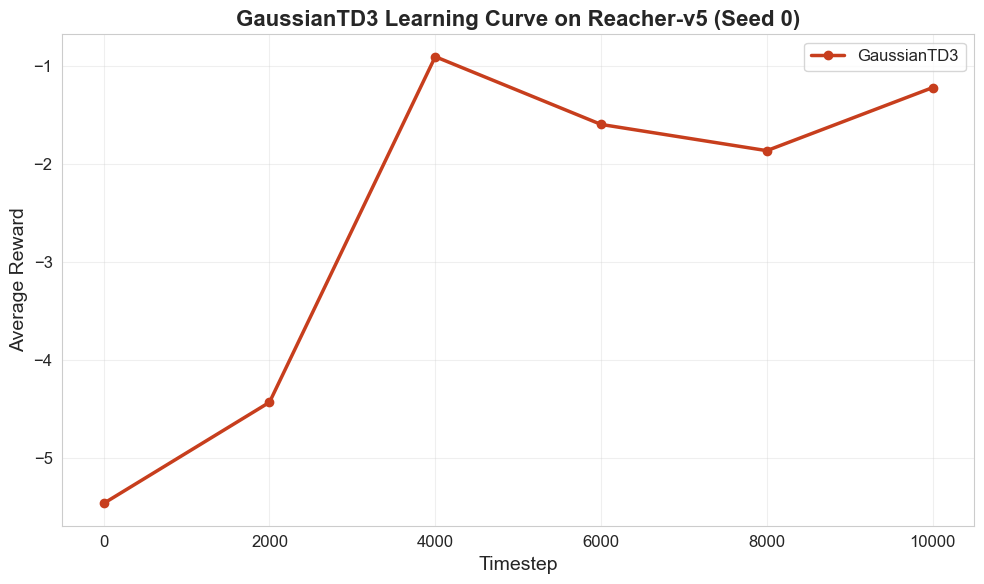

In [7]:
# Train GaussianTD3
gaussiantd3_evaluations, gaussiantd3_timesteps = train_algorithm(
    policy_name="GaussianTD3",
    env_name=ENV_NAME,
    seed=SEED,
    max_timesteps=MAX_TIMESTEPS,
    start_timesteps=START_TIMESTEPS,
    eval_freq=EVAL_FREQ,
    batch_size=BATCH_SIZE,
    discount=DISCOUNT,
    tau=TAU,
    policy_noise=POLICY_NOISE,
    noise_clip=NOISE_CLIP,
    policy_freq=POLICY_FREQ,
    expl_noise=EXPL_NOISE,
    alpha=ALPHA
)

# Store results for comparison
all_results["GaussianTD3"] = {"evaluations": gaussiantd3_evaluations, "timesteps": gaussiantd3_timesteps}

# Plot GaussianTD3 learning curve
plt.figure(figsize=(10, 6))
plt.plot(gaussiantd3_timesteps, gaussiantd3_evaluations, marker='o', linewidth=2.5, markersize=6, label="GaussianTD3", color='#C73E1D')
plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Average Reward', fontsize=14)
plt.title(f'GaussianTD3 Learning Curve on {ENV_NAME} (Seed {SEED})', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Algorithm Comparison

Compare all algorithms on a single plot and generate a comparison table.


### Plot from Current Training Results



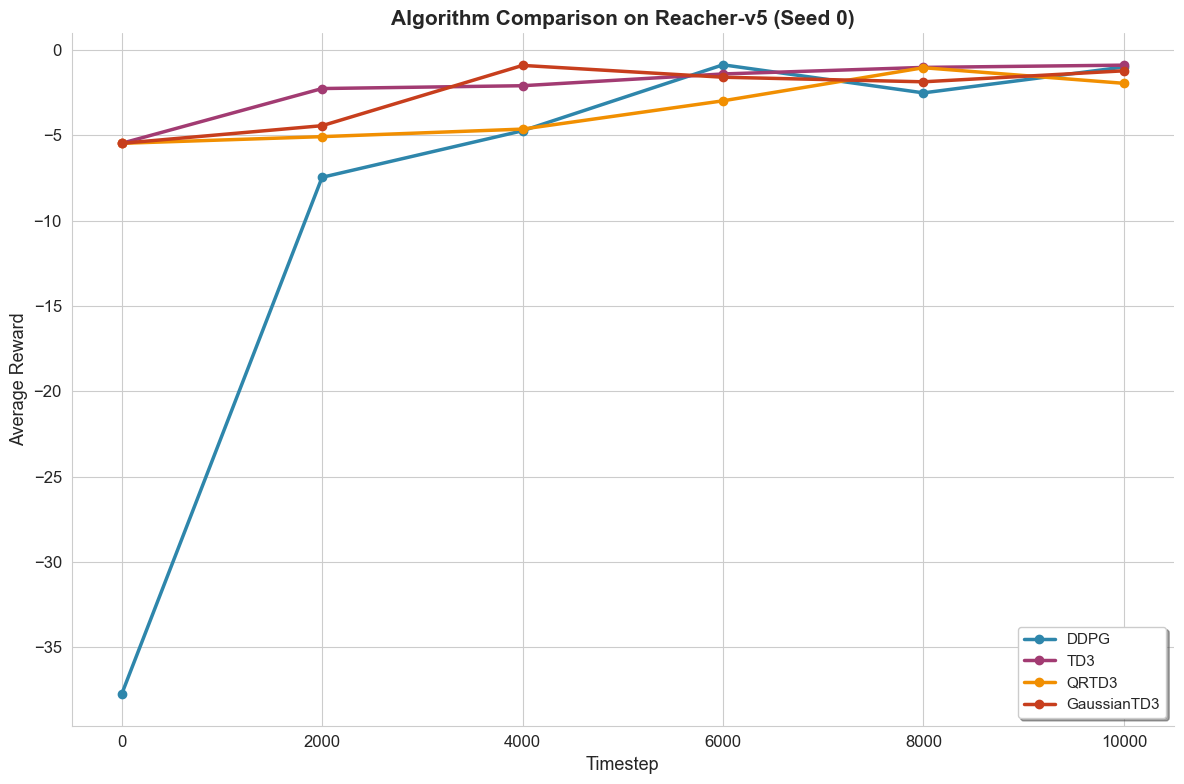


Algorithm Comparison Summary (Single Seed)
  Algorithm Initial Reward Final Reward Max Reward Improvement  Num Evaluations
       DDPG        -37.748       -0.998     -0.868      36.750                6
        TD3         -5.469       -0.888     -0.888       4.581                6
      QRTD3         -5.469       -1.953     -1.038       3.516                6
GaussianTD3         -5.469       -1.220     -0.903       4.249                6


In [13]:
# Plot comparison from current training session (single seed)
if all_results:
    plt.figure(figsize=(12, 8))
    
    colors = {
        'DDPG': '#2E86AB',      # Beautiful blue
        'TD3': '#A23B72',        # Rich purple
        'QRTD3': '#F18F01',      # Vibrant orange
        'GaussianTD3': '#C73E1D'  # Deep red
    }
    
    # Plot all algorithms on the same figure
    for algo_name, results in all_results.items():
        plt.plot(results['timesteps'], results['evaluations'], 
                marker='o', linewidth=2.5, markersize=6,
                label=algo_name, color=colors.get(algo_name, 'black'))
    
    # Set labels, title, legend (outside the loop)
    plt.xlabel('Timestep', fontsize=13)
    plt.ylabel('Average Reward', fontsize=13)
    plt.title(f'Algorithm Comparison on {ENV_NAME} (Seed {SEED})', 
              fontsize=15, fontweight='bold')
    plt.legend(fontsize=11, frameon=True, fancybox=True, shadow=True, loc='best')
    plt.tight_layout()
    sns.despine()
    plt.show()
    
    # Create comparison table
    comparison_data = []
    for algo_name, results in all_results.items():
        evaluations = results['evaluations']
        comparison_data.append({
            'Algorithm': algo_name,
            'Initial Reward': f"{evaluations[0]:.3f}",
            'Final Reward': f"{evaluations[-1]:.3f}",
            'Max Reward': f"{max(evaluations):.3f}",
            'Improvement': f"{evaluations[-1] - evaluations[0]:.3f}",
            'Num Evaluations': len(evaluations)
        })
    
    df = pd.DataFrame(comparison_data)
    print("\n" + "="*70)
    print("Algorithm Comparison Summary (Single Seed)")
    print("="*70)
    print(df.to_string(index=False))
    print("="*70)
else:
    print("No results available. Run the training sections above first.")


## Advanced Visualization: Loading Saved Results

This section shows how to load saved results from multiple seeds and create plots with error bars and comparison tables. This is useful when you have results saved from previous training runs.

**Note**: This section assumes you have results saved in `./results/{ENV_NAME}/{POLICY}/{seed}.npy` format.


In [16]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

def smooth(data, window):
    """Smooth data using a moving average."""
    if window <= 1:
        return data
    return np.convolve(data, np.ones(window) / window, mode='same')

def load_results_from_files(env_name, policy_name, eval_freq=5000, smooth_window=1):
    """
    Load results from saved .npy files for multiple seeds.
    
    Args:
        env_name: Name of the environment
        policy_name: Name of the policy/algorithm
        eval_freq: Evaluation frequency used during training
        smooth_window: Window size for smoothing (1 = no smoothing)
    
    Returns:
        timesteps: Array of timesteps
        mean_rewards: Mean rewards across seeds
        std_errors: Standard errors (for error bars)
        all_evaluations: List of all evaluation arrays (one per seed)
    """
    results_dir = f"./results/{env_name}/{policy_name}"
    
    if not os.path.exists(results_dir):
        print(f"Results directory not found: {results_dir}")
        return None, None, None, None
    
    # Find all seed files
    seed_files = sorted(glob(os.path.join(results_dir, "*.npy")))
    
    if not seed_files:
        print(f"No result files found in {results_dir}")
        return None, None, None, None
    
    # Load all evaluations
    all_evaluations = []
    for seed_file in seed_files:
        eval_data = np.load(seed_file)
        all_evaluations.append(eval_data)
    
    # Stack into (num_seeds, num_timesteps)
    eval_array = np.array(all_evaluations)
    num_seeds = len(all_evaluations)
    
    # Calculate mean and standard error
    mean_rewards = np.mean(eval_array, axis=0)
    std_errors = np.std(eval_array, axis=0) / np.sqrt(num_seeds)
    
    # Apply smoothing if requested
    if smooth_window > 1:
        mean_rewards = smooth(mean_rewards, smooth_window)
        std_errors = smooth(std_errors, smooth_window)
    
    # Create timesteps array
    timesteps = np.array([0 if i == 0 else i * eval_freq for i in range(len(mean_rewards))])
    
    print(f"Loaded {num_seeds} seeds for {policy_name} on {env_name}")
    
    return timesteps, mean_rewards, std_errors, all_evaluations

# Example: Load results for all algorithms
print("Loading saved results...")
loaded_results = {}

for policy in ["DDPG", "TD3", "QRTD3", "GaussianTD3"]:
    timesteps, mean_rewards, std_errors, all_evals = load_results_from_files(
        ENV_NAME, policy, eval_freq=EVAL_FREQ, smooth_window=1
    )
    if timesteps is not None:
        loaded_results[policy] = {
            'timesteps': timesteps,
            'mean_rewards': mean_rewards,
            'std_errors': std_errors,
            'all_evaluations': all_evals
        }


Loading saved results...
Loaded 5 seeds for DDPG on Reacher-v5
Loaded 5 seeds for TD3 on Reacher-v5
Results directory not found: ./results/Reacher-v5/QRTD3
Loaded 5 seeds for GaussianTD3 on Reacher-v5


### Comparison Plot with Error Bars

Create a plot with shaded error regions showing variance across seeds.


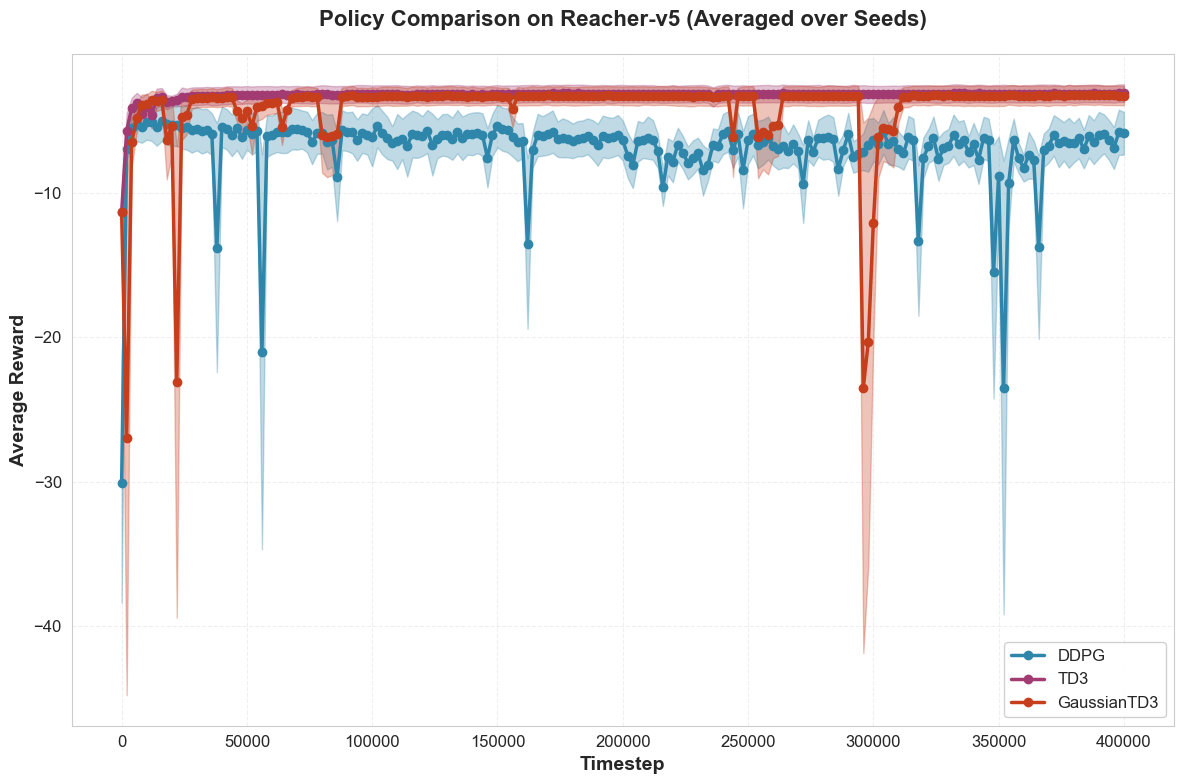


✓ Plotted 3 algorithms with error bars


In [17]:
if loaded_results:
    plt.figure(figsize=(12, 8))
    
    # Color scheme
    colors = {
        'DDPG': '#2E86AB',      # Beautiful blue
        'TD3': '#A23B72',        # Rich purple
        'QRTD3': '#F18F01',      # Vibrant orange
        'GaussianTD3': '#C73E1D'  # Deep red
    }
    
    
    # Plot each algorithm with error bars
    for policy_name, results in loaded_results.items():
        timesteps = results['timesteps']
        mean_rewards = results['mean_rewards']
        std_errors = results['std_errors']
        
        # Plot mean line
        plt.plot(timesteps, mean_rewards, 
                label=policy_name, 
                linewidth=2.5, 
                marker='o', 
                markersize=6,
                color=colors.get(policy_name, 'black'))
        
        # Fill error region (mean ± std_error)
        plt.fill_between(timesteps, 
                        mean_rewards - std_errors, 
                        mean_rewards + std_errors, 
                        alpha=0.3, 
                        color=colors.get(policy_name, 'black'))
    
    plt.xlabel('Timestep', fontsize=14, fontweight='bold')
    plt.ylabel('Average Reward', fontsize=14, fontweight='bold')
    plt.title(f'Policy Comparison on {ENV_NAME} (Averaged over Seeds)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.legend(fontsize=12, loc='best', framealpha=0.9)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Plotted {len(loaded_results)} algorithms with error bars")
else:
    print("No saved results found. Run the training sections above first, or ensure results are saved in ./results/")


### Detailed Comparison Table with Statistics

Create a comprehensive table showing statistics across all seeds for each algorithm.


In [18]:
# Create detailed comparison table with statistics
if loaded_results:
    comparison_data = []
    
    for policy_name, results in loaded_results.items():
        all_evals = results['all_evaluations']
        mean_rewards = results['mean_rewards']
        std_errors = results['std_errors']
        
        # Calculate statistics
        initial_rewards = [eval_data[0] for eval_data in all_evals]
        final_rewards = [eval_data[-1] for eval_data in all_evals]
        max_rewards = [max(eval_data) for eval_data in all_evals]
        
        num_seeds = len(all_evals)
        
        # Calculate mean ± standard error
        def format_stat(values):
            mean_val = np.mean(values)
            std_err = np.std(values) / np.sqrt(len(values)) if len(values) > 1 else 0.0
            return f"{mean_val:.2f} ± {std_err:.2f}"
        
        comparison_data.append({
            'Algorithm': policy_name,
            'Num Seeds': num_seeds,
            'Initial Reward': format_stat(initial_rewards),
            'Final Reward': format_stat(final_rewards),
            'Max Reward': format_stat(max_rewards),
            'Improvement': format_stat([f - i for f, i in zip(final_rewards, initial_rewards)]),
            'Final Mean': f"{np.mean(final_rewards):.2f}",
            'Final Std': f"{np.std(final_rewards):.2f}"
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    
    # Display table with nice formatting
    print("\n" + "="*100)
    print("Algorithm Comparison Summary (Averaged over Seeds)")
    print("="*100)
    print(df_comparison.to_string(index=False))
    print("="*100)
    
    # Also create a simpler summary table
    print("\n" + "-"*70)
    print("Final Performance Summary")
    print("-"*70)
    for policy_name, results in loaded_results.items():
        all_evals = results['all_evaluations']
        final_rewards = [eval_data[-1] for eval_data in all_evals]
        mean_final = np.mean(final_rewards)
        std_err_final = np.std(final_rewards) / np.sqrt(len(final_rewards))
        print(f"{policy_name:20s}: {mean_final:8.2f} ± {std_err_final:6.2f}")
    print("-"*70)
else:
    print("No saved results found. Run the training sections above first.")



Algorithm Comparison Summary (Averaged over Seeds)
  Algorithm  Num Seeds Initial Reward Final Reward   Max Reward  Improvement Final Mean Final Std
       DDPG          5  -30.08 ± 8.31 -5.91 ± 1.48 -4.66 ± 1.29 24.16 ± 8.09      -5.91      3.30
        TD3          5  -11.37 ± 1.57 -3.13 ± 0.61 -3.09 ± 0.61  8.24 ± 1.06      -3.13      1.37
GaussianTD3          5  -11.37 ± 1.57 -3.29 ± 0.67 -3.15 ± 0.66  8.08 ± 1.00      -3.29      1.50

----------------------------------------------------------------------
Final Performance Summary
----------------------------------------------------------------------
DDPG                :    -5.91 ±   1.48
TD3                 :    -3.13 ±   0.61
GaussianTD3         :    -3.29 ±   0.67
----------------------------------------------------------------------
